# CIL User Showcase 13: Anisotropic Regularization for FILD Measurements using CIL

Copyright 2024 Bo Simmendefeldt Schmidt and collaborators.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**Author:** Bo Simmendefeldt Schmidt  
**Affiliation:** Department of Physics and Astronomy, University of California, Irvine  
**Contact:** bo.simmendefeldt@uci.edu

This notebook demonstrates how to use the Core Imaging Library (CIL) to implement anisotropic regularization for the reconstruction of fast-ion loss detector (FILD) measurements, as described in [Simmendefeldt Schmidt et al 2024](https://doi.org/10.1088/1741-4326/ad75a5).

## Table of Contents
1. [Prerequisites](#prerequisites)
2. [Background and Overview](#background)
3. [Setup and Imports](#setup)
4. [Custom Operators](#operators)
5. [Loading Weight Functions](#weight-functions)
6. [Anisotropic Regularization Framework](#framework)
7. [Implementation and Reconstruction](#implementation)
8. [Results and Analysis](#results)

<a id="prerequisites"></a>
## 1. Prerequisites

This notebook has been tested with the following package versions:

| Package | Version |
|---------|---------|
| CIL (Core Imaging Library) | 24.2.0 |
| NumPy | 1.26.4 |
| Matplotlib | 3.9.2 |
| SciPy | 1.14.1 |
| netCDF4 | 1.7.1 |
| PyWavelets | 1.7.0 |

Later versions may also work but have not been tested.

## Data Availability

The datasets and custom files used in this notebook are publicly available at:  
https://github.com/bosschmidt/AniReg_FILD

Additional custom files required:
- `my_custom_operator.py`: Custom FILD operator implementation
- `manolo_colormap.py`: Custom colormap for visualization
- `b_2D.npy`: Experimental FILD data
- `34614_Bo_v2023_4_weight_function.nc`: Simulated system matrix

<a id="background"></a>
## 2. Background
Fast-ion loss detectors (FILDs) are diagnostic tools in experimental magnetically confined fusion plasma devices, measuring the velocity distribution of lost fast ions. The measurement principle is detailed in [Simmendefeldt Schmidt et al 2024](https://doi.org/10.1088/1361-6587/ad268f), where lost fast ions impact a plate coated with a scintillating material, emitting photons which are subsequently measured by a camera. The velocity space coordinates ($g$, $\alpha$) used in this analysis are defined in [Simmendefeldt Schmidt et al 2024](https://doi.org/10.1088/1741-4326/ad75a5), where:
- $g$ (gyroscalar): Relates to particle energy
- $\alpha$ (pitch angle): Describes the angle between particle velocity and magnetic field

However, the reconstruction of these distributions from FILD measurements is an ill-posed inverse problem requiring careful regularization.

This showcase demonstrates how CIL can be used to implement anisotropic regularization techniques that:
- Apply different regularization in different dimensions
- Improve reconstruction quality compared to traditional methods
- Preserve the physical characteristics of the fast-ion distribution

## What You'll Learn
- How to set up an anisotropic regularization problem in CIL
- How to implement different regularization strategies (Tikhonov, total variation (TV), Besov-space priors)

<a id="setup"></a>
## 3. Setup and Imports

The following section sets up the computational environment using CIL and necessary supporting libraries. Key imports include:
- CIL components for optimization and operator definitions
- Custom operators for FILD-specific computations
- Supporting libraries for data handling and visualization

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
#rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Computer Modern Roman']
#rcParams['text.usetex'] = True
rcParams.update({'font.size': 14})
from manolo_colormap import manolo_colormap
from matplotlib.colors import ListedColormap
manolo_cmap = ListedColormap(manolo_colormap(256))

from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from cil.framework import ImageGeometry
from cil.optimisation.operators import BlockOperator, FiniteDifferenceOperator, IdentityOperator, WaveletOperator
from cil.optimisation.functions import IndicatorBox, BlockFunction, L2NormSquared, L1Norm
from cil.optimisation.algorithms import PDHG
from cil.optimisation.utilities import callbacks
from my_custom_operator import MyCustomOperator


<a id="operators"></a>
## 4. Custom Operators

We implement a custom linear operator `MyCustomOperator`, defined in the file `my_custom_operator.py`,  that handles the mapping between velocity space and measurement space. This operator extends CIL's `LinearOperator` class and provides the following key functionality:

1. **Initialization**:
   - Takes a matrix `A` representing the FILD system response
   - Requires domain and range geometries to define input/output spaces
   - Allows specification of array ordering ('C' or 'F' style)

2. **Direct Operation**:
   - Implements the forward mapping from velocity space to measurement space
   - Flattens input, applies matrix multiplication, and reshapes result

3. **Adjoint Operation**:
   - Implements the backward mapping from measurement space to velocity space
   - Uses transpose of system matrix for adjoint computation

### Understanding the MyCustomOperator Implementation

Let's understand the custom FILD operator step by step. This operator handles transformations between velocity space (where the physics lives) and measurement space (where the data is collected).

#### 1. The Class Foundation (`__init__`)

The `MyCustomOperator` class inherits from CIL's `LinearOperator` and is initialized with:

```python
def __init__(self, A, domain_geometry, range_geometry, order):
```

Key Parameters:

- self: References the specific instance being created
- A: The system matrix describing the response of the FILD
- domain_geometry: Structure of velocity space
- range_geometry: Structure of measurement space
- order: How to handle array transformations ('C' or 'F' style)

The initialization process:

```python
super(MyCustomOperator, self).__init__(domain_geometry=domain_geometry, 
                                     range_geometry=range_geometry)
self.A = A
self.order = order
```

Sets up basic operator features and stores essential values for later use.

#### 2. Forward Operation (`direct`)

The `direct` method transforms velocity space data into measurement space:

```python
def direct(self, x, out=None):
```
Process flow:

**a. Flatten input**:
```python
flattened_x = x.as_array().flatten(order=self.order)
```
Converts 2D velocity space data into 1D array.

**b. Apply system response**:
```python
result_1d = np.dot(self.A, flattened_x)
```
Transforms the data using the FILD system matrix.

**c. Reshape result**:
```python
result_2d = result_1d.reshape((self.range_geometry().voxel_num_y, 
                              self.range_geometry().voxel_num_x), 
                             order=self.order)
```
Converts back to 2D measurement space format.

**d. Handle output**:
```python
if out is None:
    result = self.range_geometry().allocate()
    result.fill(result_2d)
    return result
else:
    out.fill(result_2d)
```
Returns or fills provided output with results.

#### 3. Backward Operation (`adjoint`)
The adjoint method goes from measurement space back to velocity space. The process flow mirrors the direct method but using $A^{\mathrm{T}}$ and `domain_geometry()` rather than $A$ and `range_geometry()`.

### Supporting Operators: WaveletOperator

In addition to our custom FILD operator, we use the [`WaveletOperator`](https://github.com/TomographicImaging/CIL/blob/master/Wrappers/Python/cil/optimisation/operators/WaveletOperator.py) from CIL's library for wavelet transformations. This operator implements discrete wavelet transforms for signal processing, supports various wavelet types (e.g., Haar, Daubechies), and handles both forward (analysis) and adjoint (synthesis) operations. The `WaveletOperator` is useful in our FILD analysis for implementing Besov-space prior regularization.



<a id="weight-functions"></a>
## 5. Loading FILD Weight Functions 

The weight functions describe how the FILD system maps fast ions with specific velocities to measurements on the detector. These are essential for:
- Constructing the forward model matrix $A_{kn}$
- Mapping between velocity space and measurement space

### Weight Function Properties
- Physical meaning: Each row represents the detector response to a specific velocity-space point
- Dimensions: $[g \times \alpha]$ for velocity space, identical to measurement coordinates
- Normalization: Weight functions are normalized for numerical stability

In [2]:
file_name = '34614_Bo_v2023_4_weight_function.nc'

# Open the NetCDF file
nc_data = Dataset(file_name, mode='r')

# Extract variables
x = np.array(nc_data.variables['y'][:])
y = np.array(nc_data.variables['x'][:])
xs = np.array(nc_data.variables['ys'][:])
ys = np.array(nc_data.variables['xs'][:])
X, Y = np.meshgrid(x, y)
new_x = np.linspace(min(x), max(x), 92)
new_y = np.linspace(min(y), max(y), 52)
new_X, new_Y = np.meshgrid(new_x, new_y)
new_points = np.array([new_Y.ravel(), new_X.ravel()]).T

W = np.array(nc_data.variables['__xarray_dataarray_variable__'][:])
new_shape = (W.shape[0] * W.shape[1], W.shape[2] * W.shape[3])
W = W.reshape(new_shape)
W /= np.linalg.norm(W)

# Close the file
nc_data.close()

Interpolate weight functions to higher different dimension on domain geometry to generate the forward operator:

In [3]:
W_for = np.zeros((len(xs)*len(ys), len(new_x)*len(new_y)))

for i in range(W_for.shape[0]):
    W_temp = np.reshape(W[i, :], (len(y), len(x)))
    interpolator = RegularGridInterpolator((y, x), W_temp)
    W_temp_interpolated = interpolator(new_points).reshape(len(new_y), len(new_x))
    W_temp_row = W_temp_interpolated.ravel()
    W_for[i, :] = W_temp_row

<a id="framework"></a>
## 6. Anisotropic Regularization Framework

### Motivation from FILD Data Characteristics

FILD measurements have distinct behaviors in different dimensions:
- **Gyroscalar ($g$)**: Shows highly localized peaks corresponding to specific particle energies (e.g., from neutral beam injection (NBI)).
- **Pitch Angle ($\alpha$)**: Exhibits broader, continuous distributions reflecting the pitch-angle spreading of particle velocities.

These fundamentally different characteristics suggest that applying the same regularization to both dimensions is suboptimal. Instead, we implement an anisotropic approach that treats each dimension independently.

### Mathematical Framework

The anisotropic regularization is formulated as the optimization problem:

$$
f^* = \underset{f}{\text{argmin}} \|Af - m\|_2^2 + \lambda^g R^g(f) + \lambda^\alpha R^\alpha(f) \quad \text{subject to } f \geq 0
$$

where:
- $f^*$ is the reconstructed velocity distribution
- $A$ is the FILD system matrix
- $m$ is the measurement data
- $\lambda^g, \lambda^\alpha$ are regularization parameters
- $R^g, R^\alpha$ are regularization functionals for each dimension.


### Regularization Methods
We implement three regularization strategies:

1. **First-Order Tikhonov Regularization**
  - Promotes smoothness through gradient penalization
  - Particularly suitable for the continuous pitch-angle distributions

2. **Total Variation (TV)**
  - Preserves sharp edges
  - Well-suited for the localized features in gyroscalar

3. **Besov-Space Prior**
  - Multi-scale wavelets-based approach
  - Effectively handles both smooth and localized features

<a id="implementation"></a>
## 7. Implementation and Reconstruction of Fast-Ion Velocity Distributions

### Numerical Implementation

We solve the anisotropic regularization problem using the Chambolle-Pock primal-dual hybrid gradient (PDHG) algorithm, which is well-suited for handling non-smooth convex optimization problems. The algorithm addresses problems of the form:

$$
\underset{f}{\text{argmin}} \; F(Kf) + G(f)
$$

where $F$ corresponds to our data fidelity and regularization terms, and $G$ enforces non-negativity. In our implementation, we expand $F(Kf)$ into component functionals:

$$
F(Kf) = \sum_j F_j(K_jf).
$$

Specifically, we structure our problem with:

$$
F = \begin{pmatrix} F_1 \\ F_2 \\ F_3 \end{pmatrix} = \begin{pmatrix} \|\cdot - m\|_2 \\ \lambda^g\|\cdot\|_{p_g} \\ \lambda^\alpha\|\cdot\|_{p_\alpha} \end{pmatrix}, \quad
K = \begin{pmatrix} K_1 \\ K_2 \\ K_3 \end{pmatrix} = \begin{pmatrix} A \\ L_g \\ L_\alpha \end{pmatrix}
$$

where:
- $L_g$ and $L_\alpha$ are operators (differential or wavelet transform) for each dimension
- $p_g$ and $p_\alpha$ can be 1 or 2, depending on the chosen regularization
- Non-negativity is enforced through the constraint $G(f) = \mathbb{I}_{\mathbb{R}_+}(f)$.

### Reconstruction Test Cases

We validate our implementation using both synthetic and experimental data:

1. **Synthetic Data Test Case**
  - Based on realistic fast-ion distributions from NBI sources
  - Includes 10% measurement noise and 1% background noise
  - Allows quantitative assessment of reconstruction accuracy

2. **Experimental Data Test Case**
  - From discharge #34614 at ASDEX Upgrade
  - Measurements from FILD1 during edge-localized mode (ELM) activity
  - Demonstrates performance with real diagnostic data

### Generate synthetic data:

In [4]:
full_dist = np.zeros((len(new_y), len(new_x)))
mu_p = 55
sigma_p = 7
mu_r1 = 3.17582418
mu_r2 = 4.36263736
mu_r3 = 5.45054945
sigma_r = 0.01

pitch_dist = (1 / (sigma_p * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((new_y - mu_p) / sigma_p) ** 2)
pitch_dist /= pitch_dist.max()
gyro_dist_1 = (1 / (sigma_r * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((new_x - mu_r1) / sigma_r) ** 2)
gyro_dist_1 /= gyro_dist_1.max()
gyro_dist_2 = (1 / (sigma_r * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((new_x - mu_r2) / sigma_r) ** 2)
gyro_dist_2 /= gyro_dist_2.max()
gyro_dist_3 = (1 / (sigma_r * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((new_x - mu_r3) / sigma_r) ** 2)
gyro_dist_3 /= gyro_dist_3.max()
gyro_dist = gyro_dist_1 * 0.1 + gyro_dist_2 * 0.2 + gyro_dist_3 * 0.7

full_dist = np.outer(pitch_dist, gyro_dist)
ground_truth = full_dist

s_full_dist = np.dot(W_for, full_dist.flatten())

noise1 = 0.1 * s_full_dist * np.random.randn(*s_full_dist.shape)
noise2 = 0.01 * np.max(s_full_dist) * np.random.randn(*s_full_dist.shape)
b = s_full_dist + noise1 + noise2
b /= np.linalg.norm(b)
b_2D = b.reshape((51,91))

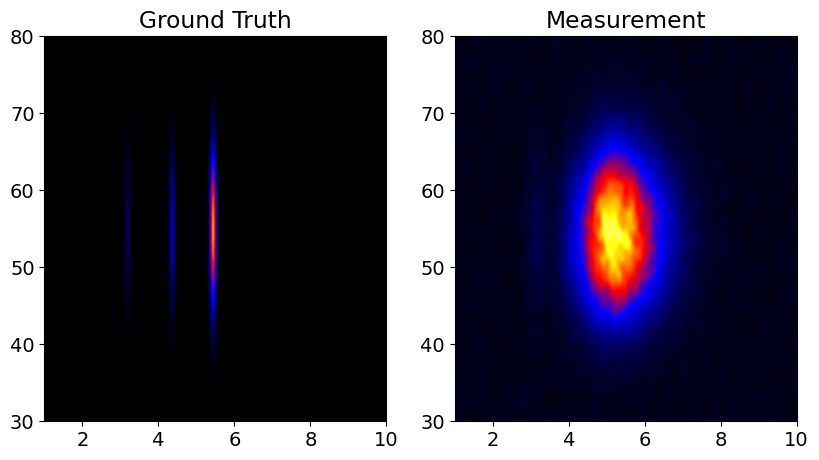

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(ground_truth, cmap=manolo_cmap, interpolation='bicubic', label='True', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto'); plt.title('Ground Truth')
plt.subplot(132); plt.imshow(b_2D, cmap=manolo_cmap, interpolation='bicubic', label='True', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto'); plt.title('Measurement')
plt.show()

### Implementation in CIL

We implement our anisotropic regularization framework using CIL's optimization tools, specifically:
- [`BlockOperator`](https://github.com/TomographicImaging/CIL/blob/master/Wrappers/Python/cil/optimisation/operators/BlockOperator.py) for combining multiple operators
- [`BlockFunction`](https://github.com/TomographicImaging/CIL/blob/master/Wrappers/Python/cil/optimisation/functions/BlockFunction.py) for combining multiple functionals
- [`PDHG`](https://github.com/TomographicImaging/CIL/blob/master/Wrappers/Python/cil/optimisation/algorithms/PDHG.py) algorithm for solving the optimization problem

The implementation for Besov-space priors follows these steps:

1. **Setup Geometries**
```python
dg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)  # Domain geometry
rg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)  # Range geometry
```
This defines the velocity space dimensions ($91 \times 51$ pixels).

2. **Data Container Setup**
```python
b_container = rg.allocate()
b_container.fill(b_2D)     # Fill with FILD measurement data
```

3. **Function Block Setup**
```python
omega = 1e4    # Data fidelity weight
alpha = 1e-2   # Gyroscalar regularization weight
beta = 1e-4    # Pitch-angle regularization weight

F1 = omega*L2NormSquared(b=b_container)  # Data fidelity term
F2 = alpha*L1Norm()                      # Gyroscalar regularization
F3 = beta*L1Norm()                       # Pitch-angle regularization
F = BlockFunction(F1, F2, F3)
```
This implements our functional $F$ with components:

- $F_1$: Data fidelity term $\omega \|Af - m\|_2^2$
- $F_2$: Gyroscalar regularization $\alpha \|L_gf \|_1$
- $F_3$: Pitch-angle regularization $\beta \|L_\alpha f \|_1$

4. **Operator Block Setup**
```python
A = MyCustomOperator(W, dg, rg, order='C')         # FILD system matrix
Dy = WaveletOperator(domain_geometry=dg, level=4,   # Wavelet transform for g
                     wname="db2", axes=(0,))
Dx = WaveletOperator(domain_geometry=dg, level=4,   # Wavelet transform for α
                     wname="db2", axes=(1,))
K = BlockOperator(A, Dy, Dx, shape=(3,1))
```
This implements our operator $K = [A; L_g; L_\alpha]$ where:

- $A$ is our custom FILD operator
- $L_g, L_\alpha$ are wavelet transforms (Daubechies-2, 4 levels)

5. **Non-negativity Constraint**
```python
G = IndicatorBox(lower=0)  # Enforces f ≥ 0
```

6. **PDHG Algorithm Setup and Run**
```python
sigma = 1.0  # Primal step size
initial = dg.allocate(0.0)  # Zero initial guess

pdhg_algorithm = PDHG(initial=initial, f=F, g=G, operator=K, 
                      sigma=sigma)
results = pdhg_algorithm.run(2000, verbose=2)
result = pdhg_algorithm.get_output()
```
The implementation uses Daubechies-2 wavelets for both dimensions, though their effect is controlled separately through the weights $\alpha$ and $\beta$. The PDHG algorithm iterates for 2000 iterations, providing the reconstructed velocity distribution.

### Besov prior decoupled in both directions

In [6]:
dg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
rg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
b_container = rg.allocate()
b_container.fill(b_2D)
zeros_container = dg.allocate()
zeros_container.fill(np.zeros((51,91)))

# Separable sum as BlockFunction
omega = 1e4
alpha = 1e-2
beta = 1e-4
F1 = omega*L2NormSquared(b=b_container)
F2 = alpha*L1Norm()
F3 = beta*L1Norm()
F = BlockFunction(F1, F2, F3)

# BlockOperator
A = MyCustomOperator(W, dg, rg, order='C')
Dy = WaveletOperator(domain_geometry=dg, level=4, wname="db2", axes=(0,))
Dx = WaveletOperator(domain_geometry=dg, level=4, wname="db2", axes=(1,))
K = BlockOperator(A, Dy, Dx, shape=(3,1))

# Constraint
G = IndicatorBox(lower = 0)

# Primal-dual step sizes
sigma = 1.0
initial = dg.allocate(0.0)

pdhg_algorithm = PDHG(initial=initial, f=F, g=G, operator=K, sigma=sigma, update_objective_interval=200)
pdhg_algorithm.run(2000, verbose=2, callbacks=[callbacks.TextProgressCallback()])
result = pdhg_algorithm.get_output()
result_array = result.array

     0/2000       ?it/s
   200/2000    3.90it/s, objective=+3.166e+02
   400/2000    3.95it/s, objective=+1.908e+02
   600/2000    3.99it/s, objective=+1.515e+02
   800/2000    4.00it/s, objective=+1.436e+02
  1000/2000    4.00it/s, objective=+1.375e+02
  1200/2000    4.00it/s, objective=+1.356e+02
  1400/2000    4.00it/s, objective=+1.347e+02
  1600/2000    4.01it/s, objective=+1.336e+02
  1800/2000    4.00it/s, objective=+1.339e+02
  2000/2000    4.01it/s, objective=+1.331e+02
  2000/2000    4.00it/s



Text(0.5, 1.0, 'Reconstruction')

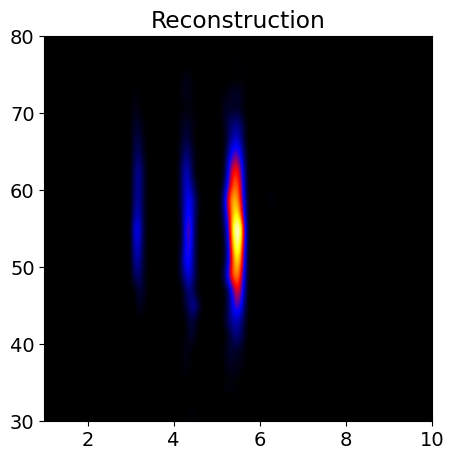

In [7]:
result_array_2D = result_array.reshape((51,91))
interpolator = RegularGridInterpolator((y, x), result_array_2D)
result_array_2D = interpolator(new_points).reshape(len(new_y), len(new_x))
result_array_2D = result_array_2D * 0.7/np.max(result_array_2D)

plt.figure(figsize=(5,5))
plt.imshow(result_array_2D, cmap=manolo_cmap, interpolation='bicubic', label='True', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto'); plt.title('Reconstruction')

### Isotropic Zeroth-Order Tikhonov Regularization:

Slightly modified version from Besov-space prior in the obvious ways.

In [8]:
dg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
rg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
b_container = rg.allocate()
b_container.fill(b_2D)

# Separable sum as BlockFunction
omega = 1e4
alpha = 2e-2
F1 = omega*L2NormSquared(b=b_container)
F2 = alpha*L2NormSquared()
F = BlockFunction(F1, F2)

# BlockOperator
A = MyCustomOperator(W, dg, rg, order='C')
I = IdentityOperator(dg)
K = BlockOperator(A, I, shape=(2,1))

# Constraint
G = IndicatorBox(lower = 0)

# Primal-dual step sizes
sigma = 1.0
initial = dg.allocate(0.0)

pdhg_algorithm = PDHG(initial=initial, f=F, g=G, operator=K, sigma=sigma, update_objective_interval=200)
pdhg_algorithm.run(2000, verbose=2, callbacks=[callbacks.TextProgressCallback()])
result = pdhg_algorithm.get_output()
result_array = result.array

     0/2000       ?it/s
   200/2000    4.22it/s, objective=+1.604e+02
   400/2000    4.21it/s, objective=+1.519e+02
   600/2000    4.20it/s, objective=+1.479e+02
   800/2000    4.20it/s, objective=+1.453e+02
  1000/2000    4.21it/s, objective=+1.436e+02
  1200/2000    4.22it/s, objective=+1.425e+02
  1400/2000    4.22it/s, objective=+1.417e+02
  1600/2000    4.22it/s, objective=+1.410e+02
  1800/2000    4.24it/s, objective=+1.405e+02
  2000/2000    4.26it/s, objective=+1.400e+02
  2000/2000    4.23it/s



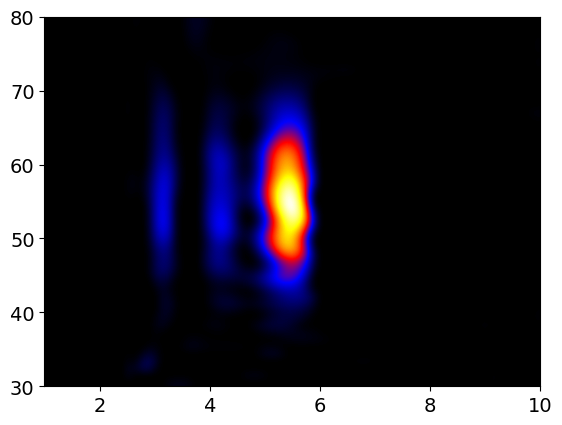

In [9]:
result_array_2D = result_array.reshape((51,91))
interpolator = RegularGridInterpolator((y, x), result_array_2D)
result_array_2D = interpolator(new_points).reshape(len(new_y), len(new_x))
result_array_2D = result_array_2D * 0.7/np.max(result_array_2D)

fig, ax = plt.subplots()
im = ax.imshow(result_array_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower',extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

### Key observations:
- Sharp peaks in $g$ are better preserved with anisotropic methods
- Pitch angle distributions remain physically meaningful (no blobs)
- Noise suppression achieved without over-smoothing

## Experimental data reconstructions

### Load 34614 Weight Function

In [10]:
file_name = '34614_Bo_v2023_4_weight_function.nc'

# Open the NetCDF file
nc_data = Dataset(file_name, mode='r')

# Extract variables
x = np.array(nc_data.variables['y'][:])
y = np.array(nc_data.variables['x'][:])
xs = np.array(nc_data.variables['ys'][:])
ys = np.array(nc_data.variables['xs'][:])
W = np.array(nc_data.variables['__xarray_dataarray_variable__'][:])

new_shape = (W.shape[0] * W.shape[1], W.shape[2] * W.shape[3])
W = W.reshape(new_shape)
W /= np.linalg.norm(W)

# Close the file
nc_data.close()

### Load Data

In [11]:
b_2D = np.load('b_2D.npy')

### Anisotropic Besov-space prior regularization

In [12]:
dg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
rg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
b_container = rg.allocate()
b_container.fill(b_2D)
zeros_container = dg.allocate()
zeros_container.fill(np.zeros((51,91)))

# Separable sum as BlockFunction
omega = 1e4
alpha = 1e-1
beta = 9e-3
F1 = omega*L2NormSquared(b=b_container)
F2 = alpha*L1Norm()
F3 = beta*L1Norm()
F = BlockFunction(F1, F2, F3)

# BlockOperator
A = MyCustomOperator(W, dg, rg, order='C')
Dy = WaveletOperator(domain_geometry=dg, level=4, wname="db2", axes=(0,))
Dx = WaveletOperator(domain_geometry=dg, level=4, wname="db2", axes=(1,))
K = BlockOperator(A, Dy, Dx, shape=(3,1))

# Constraint
mask = np.ones_like(b_2D)
mask[b_2D < 0.006] = 0
muA = 1e6
G = IndicatorBox(lower=0, upper=muA * mask)

# Primal-dual step sizes
sigma = 1.0
initial = dg.allocate(0.0)

pdhg_algorithm = PDHG(initial=initial, f=F, g=G, operator=K, sigma=sigma, update_objective_interval=200)

In [13]:
pdhg_algorithm.run(3000, verbose=2, callbacks=[callbacks.TextProgressCallback()])
result = pdhg_algorithm.get_output()
result_array = result.array

     0/3000       ?it/s
   200/3000    3.79it/s, objective=+1.027e+03
   400/3000    3.81it/s, objective=+3.916e+02
   600/3000    3.82it/s, objective=+2.795e+02
   800/3000    3.81it/s, objective=+2.252e+02
  1000/3000    3.81it/s, objective=+1.989e+02
  1200/3000    3.82it/s, objective=+1.863e+02
  1400/3000    3.82it/s, objective=+1.716e+02
  1600/3000    3.82it/s, objective=+1.543e+02
  1800/3000    3.83it/s, objective=+1.518e+02
  2000/3000    3.81it/s, objective=+1.493e+02
  2200/3000    3.81it/s, objective=+1.416e+02
  2400/3000    3.80it/s, objective=+1.381e+02
  2600/3000    3.80it/s, objective=+1.360e+02
  2800/3000    3.80it/s, objective=+1.348e+02
  3000/3000    3.80it/s, objective=+1.336e+02
  3000/3000    3.81it/s



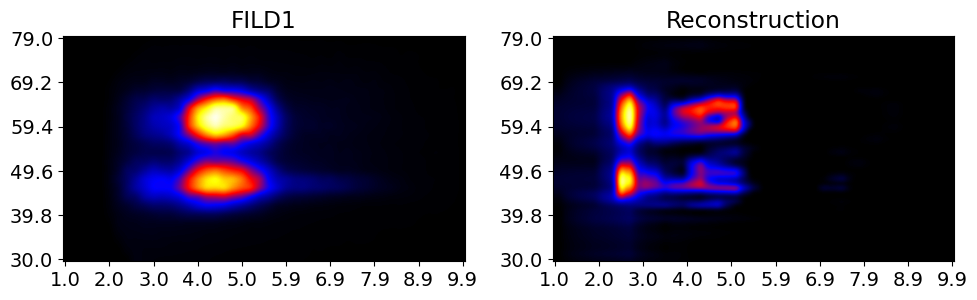

In [24]:
result_array_2D = result_array.reshape((51,91))

num_xticks = 10;num_yticks = 6;xtick_positions = np.linspace(0, b_2D.shape[1]-1, num_xticks).astype(int);xtick_labels = np.round(new_x[xtick_positions], 1)
ytick_positions = np.linspace(0, b_2D.shape[0]-1, num_yticks).astype(int);ytick_labels = np.round(new_y[ytick_positions], 1)

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121);im1 = ax1.imshow(b_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower');ax1.set_title('FILD1')
ax1.set_xticks(xtick_positions);ax1.set_xticklabels(xtick_labels);ax1.set_yticks(ytick_positions);ax1.set_yticklabels(ytick_labels)
ax2 = plt.subplot(122);im2 = ax2.imshow(result_array_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower');ax2.set_title('Reconstruction')
ax2.set_xticks(xtick_positions);ax2.set_xticklabels(xtick_labels);ax2.set_yticks(ytick_positions);ax2.set_yticklabels(ytick_labels)

plt.tight_layout()

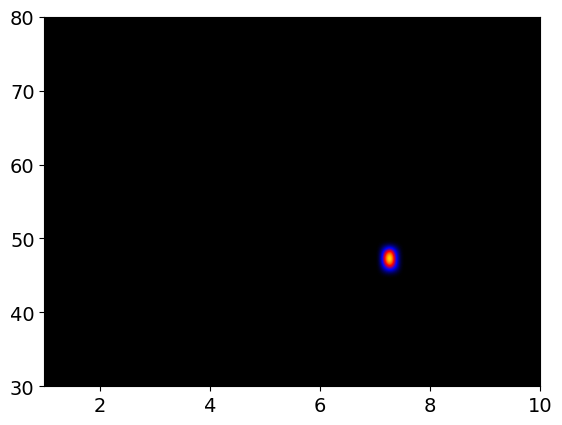

In [15]:
result_array_2D_HEF = result_array_2D.copy()
result_array_2D_HEF[:, 0:49] = 0
fig, ax = plt.subplots()
im = ax.imshow(result_array_2D_HEF, cmap=manolo_cmap, interpolation='bicubic', origin='lower', extent=[new_x.min(), new_x.max(), new_y.min(), new_y.max()], aspect='auto')


### Zeroth-Order Tikhonov Regularization

In [16]:
dg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
rg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
b_container = rg.allocate()
b_container.fill(b_2D)

# Separable sum as BlockFunction
omega = 1e4
alpha = 1e-2
F1 = omega*L2NormSquared(b=b_container)
F2 = alpha*L2NormSquared()
F = BlockFunction(F1, F2)

# BlockOperator
A = MyCustomOperator(W, dg, rg, order='C')
I = IdentityOperator(dg)
K = BlockOperator(A, I, shape=(2,1))

# Constraint
G = IndicatorBox(lower = 0)

# Primal-dual step sizes
sigma = 1.0
initial = dg.allocate(0.0)

pdhg_algorithm = PDHG(initial=initial, f=F, g=G, operator=K, sigma=sigma, update_objective_interval=200)
pdhg_algorithm.run(2000, verbose=2, callbacks=[callbacks.TextProgressCallback()])
result = pdhg_algorithm.get_output()
result_array = result.array

     0/2000       ?it/s
   200/2000    4.24it/s, objective=+1.421e+02
   400/2000    4.25it/s, objective=+8.373e+01
   600/2000    4.27it/s, objective=+7.256e+01
   800/2000    4.28it/s, objective=+6.768e+01
  1000/2000    4.27it/s, objective=+6.484e+01
  1200/2000    4.25it/s, objective=+6.296e+01
  1400/2000    4.25it/s, objective=+6.160e+01
  1600/2000    4.24it/s, objective=+6.058e+01
  1800/2000    4.24it/s, objective=+5.977e+01
  2000/2000    4.24it/s, objective=+5.912e+01
  2000/2000    4.25it/s



<>:6: SyntaxWarning: invalid escape sequence '\#'
<>:6: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipykernel_442696/1845073487.py:6: SyntaxWarning: invalid escape sequence '\#'
  ax1 = plt.subplot(121);im1 = ax1.imshow(b_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower');ax1.set_title('FILD1 \#34614')


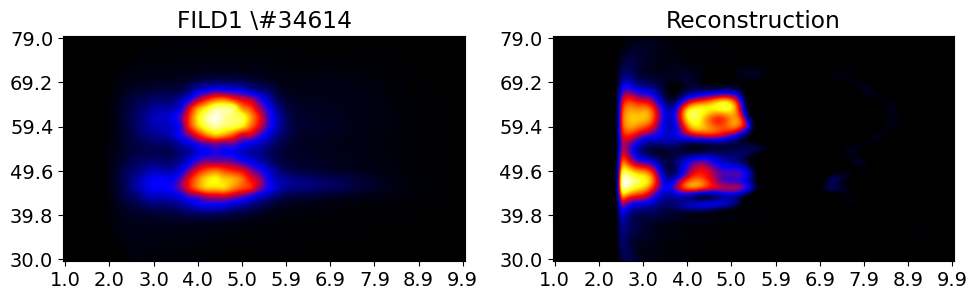

In [17]:
result_array_2D = result_array.reshape((51,91))
num_xticks = 10;num_yticks = 6;xtick_positions = np.linspace(0, b_2D.shape[1]-1, num_xticks).astype(int);xtick_labels = np.round(new_x[xtick_positions], 1)
ytick_positions = np.linspace(0, b_2D.shape[0]-1, num_yticks).astype(int);ytick_labels = np.round(new_y[ytick_positions], 1)

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121);im1 = ax1.imshow(b_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower');ax1.set_title('FILD1 \#34614')
ax1.set_xticks(xtick_positions);ax1.set_xticklabels(xtick_labels);ax1.set_yticks(ytick_positions);ax1.set_yticklabels(ytick_labels)
ax2 = plt.subplot(122);im2 = ax2.imshow(result_array_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower');ax2.set_title('Reconstruction')
ax2.set_xticks(xtick_positions);ax2.set_xticklabels(xtick_labels);ax2.set_yticks(ytick_positions);ax2.set_yticklabels(ytick_labels)

plt.tight_layout()

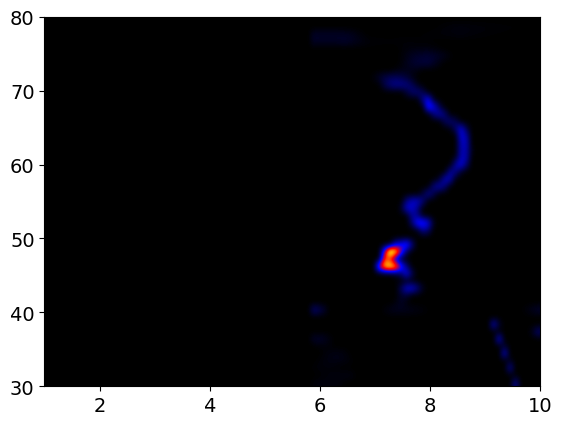

In [18]:
result_array_2D_HEF = result_array_2D.copy()
result_array_2D_HEF[:, 0:49] = 0
fig, ax = plt.subplots()
im = ax.imshow(result_array_2D_HEF, cmap=manolo_cmap, interpolation='bicubic', origin='lower', extent=[new_x.min(), new_x.max(), new_y.min(), new_y.max()], aspect='auto')

### Combined anisotropic regularization: Besov-space prior in $\rho$ and first-order Tikhonov regularization in $\alpha$

In [19]:
dg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
rg = ImageGeometry(voxel_num_x=91, voxel_num_y=51)
b_container = rg.allocate()
b_container.fill(b_2D)
zeros_container = dg.allocate()
zeros_container.fill(np.zeros((51,91)))

# Separable sum as BlockFunction
omega =  1e4
alpha = 5e-4
beta = 1e-2
F1 = omega*L2NormSquared(b=b_container)
F2 = alpha*L2NormSquared(b=zeros_container)
F3 = beta*L1Norm()
F = BlockFunction(F1, F2, F3)

# BlockOperator
A = MyCustomOperator(W, dg, rg, order='C')
Ly = FiniteDifferenceOperator(dg, direction='horizontal_y')
Dx = WaveletOperator(domain_geometry=dg, level=4, wname="db2", axes=(1,))
K = BlockOperator(A, Ly, Dx, shape=(3,1))

# Constraint
G = IndicatorBox(lower = 0)

# Primal-dual step sizes
sigma = 1.0
initial = dg.allocate(0.0)

pdhg_algorithm = PDHG(initial=initial, f=F, g=G, operator=K, sigma=sigma, update_objective_interval=200)

In [20]:
pdhg_algorithm.run(2000, verbose=2, callbacks=[callbacks.TextProgressCallback()])
result = pdhg_algorithm.get_output()
result_array = result.array

     0/2000       ?it/s


   200/2000    3.95it/s, objective=+1.436e+03
   400/2000    3.93it/s, objective=+6.931e+02
   600/2000    3.92it/s, objective=+3.161e+02
   800/2000    3.92it/s, objective=+2.910e+02
  1000/2000    3.92it/s, objective=+1.297e+02
  1200/2000    3.92it/s, objective=+1.215e+02
  1400/2000    3.93it/s, objective=+9.645e+01
  1600/2000    3.92it/s, objective=+9.487e+01
  1800/2000    3.90it/s, objective=+7.758e+01
  2000/2000    3.90it/s, objective=+7.520e+01
  2000/2000    3.91it/s



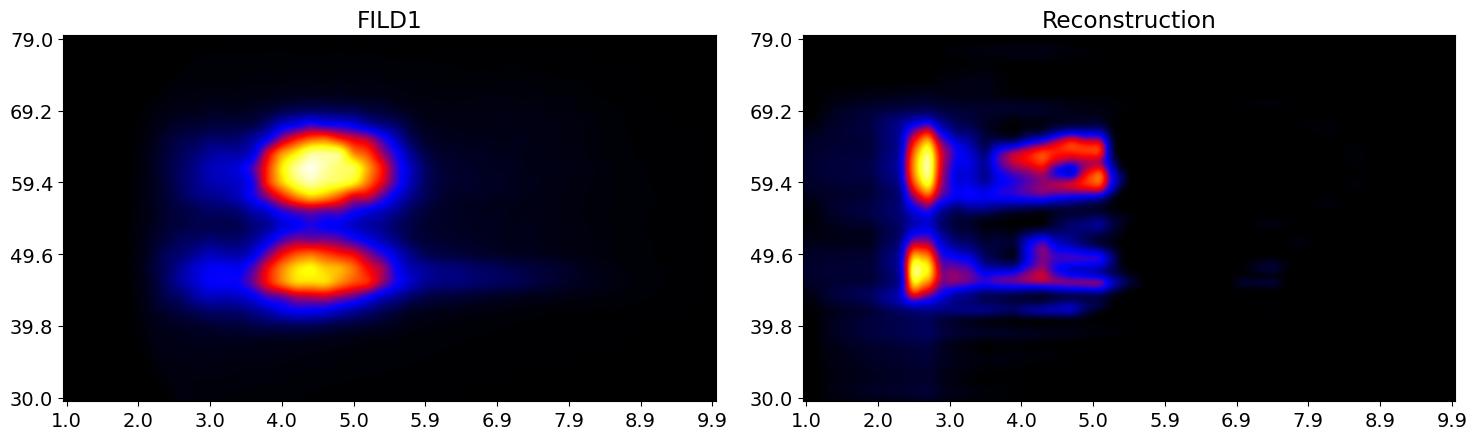

In [23]:
result_array_2D = result_array.reshape((51,91))
num_xticks = 10;num_yticks = 6;xtick_positions = np.linspace(0, b_2D.shape[1]-1, num_xticks).astype(int);xtick_labels = np.round(new_x[xtick_positions], 1)
ytick_positions = np.linspace(0, b_2D.shape[0]-1, num_yticks).astype(int);ytick_labels = np.round(new_y[ytick_positions], 1)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121);im1 = ax1.imshow(b_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower');ax1.set_title('FILD1')
ax1.set_xticks(xtick_positions);ax1.set_xticklabels(xtick_labels);ax1.set_yticks(ytick_positions);ax1.set_yticklabels(ytick_labels)
ax2 = plt.subplot(122);im2 = ax2.imshow(result_array_2D, cmap=manolo_cmap, interpolation='bicubic', origin='lower');ax2.set_title('Reconstruction')
ax2.set_xticks(xtick_positions);ax2.set_xticklabels(xtick_labels);ax2.set_yticks(ytick_positions);ax2.set_yticklabels(ytick_labels)

plt.tight_layout()

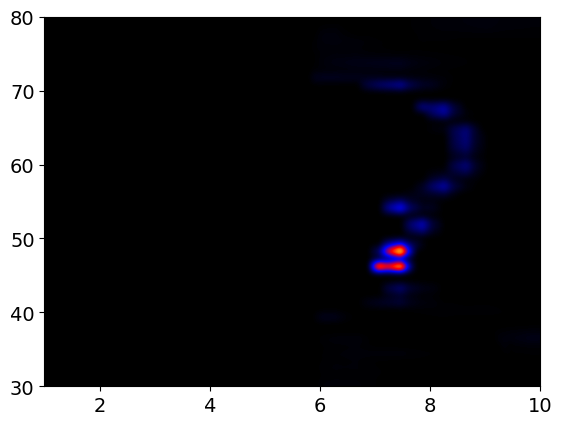

In [22]:
result_array_2D_HEF = result_array_2D.copy()
result_array_2D_HEF[:, 0:49] = 0
fig, ax = plt.subplots()
im = ax.imshow(result_array_2D_HEF, cmap=manolo_cmap, interpolation='bicubic', origin='lower', extent=[new_x.min(), new_x.max(), new_y.min(), new_y.max()], aspect='auto')

<a id="results"></a>
## 8. Application to ASDEX Upgrade Data: Comparative Analysis

Our analysis demonstrates that the choice of regularization strategy impacts the quality of FILD reconstructions. Here we compare the performance of different methods:

### Performance Analysis

#### Anisotropic Besov-Space Prior
- **Superior Feature Resolution**: Accurately captures both sharp peaks in gyroscalar and smooth distributions in pitch angle
- **High-Energy Features**: Resolves the acceleration of ions to over twice the injection energy
- **Pitch-Angle Structure**: Reveals fine structure in pitch-angle splitting during ELM activity
- **Physical Consistency**: Reconstructions align well with expected fast-ion behavior and ASCOT simulations

#### Traditional Isotropic Tikhonov
- **Limited Resolution**: Compromises sharp features in gyroscalar to maintain stability
- **Feature Loss**: High-energy features become diffuse and harder to interpret
- **Regularization Trade-off**: Cannot simultaneously achieve noise suppression and feature preservation
- **Physical Interpretation**: Limits detailed analysis of fast-ion dynamics

#### Hybrid Anisotropic Approach (First-Order Tikhonov with Besov)
- **Improved Edge Definition**: Better preservation of sharp features compared to isotropic methods
- **Stability**: Enhanced noise suppression while maintaining key features
- **Performance Gap**: While superior to isotropic methods, falls short of pure Besov-space prior implementation

### Key Findings

The anisotropic Besov-space prior approach emerges as the optimal choice for FILD reconstruction because it:
1. Respects the inherent anisotropic nature of fast-ion velocity distributions
2. Preserves physical features while suppressing noise
3. Enables analysis of complex phenomena like ELM-induced fast-ion acceleration
4. Provides reconstructions that support physical interpretation

These results suggest that future FILD analysis should prioritize anisotropic regularization methods, particularly those utilizing Besov-space priors.